# Анализ системы метрик приложения

## Цели и задачи проекта

Проект представляет собой анализ юнит-экономики приложения с развлекательным контентом. Согласно бизнес-модели продукта, привлечение должно окупиться за первые 28 дней (4 недели), но в последнее время выручка начала стагнировать и нужно разобраться в причинах. В начале июня отдел маркетинга внедрил новую стратегию привлечения клиентов, нужно оценить её успешность.

Для этого проведём когортный анализ пользователей, рассчитаем CAC, LTV и ROI по каналам привлечения и дадим рекомендации маркетинговому отделу.  

## Структура проекта

1. Загрузка и предобработка данных.
2. Подготовка данных к когортному анализу.
3. Анализ месячной динамики основных метрик продукта.
4. Анализ метрик в разрезе источника привлечения.
5. Анализ периода окупаемости маркетинговых вложений.
6. Выводы и рекомендации.

## Описание данных

1. Датасет `ppro_visits.csv` — информация о посещениях приложения пользователями, которые зарегистрировались с 1 апреля 2024 года по 30 ноября 2024 года:
    - `user_id` — уникальный идентификатор пользователя;
    - `region` — страна пользователя;
    - `device` — категория устройства пользователя;
    - `channel` — идентификатор рекламного источника, из которого пришёл пользователь;
    - `session_start` — дата и время начала сессии;
    - `session_end` — дата и время окончания сессии.

2. Датасет `ppro_orders.csv` — информация о покупках:
    - `user_id` — уникальный идентификатор пользователя, который сделал покупку;
    - `event_dt` — дата и время покупки;
    - `revenue` — выручка.

3. Датасет `ppro_costs.csv` — информация о затратах на маркетинг:
    - `dt` — дата
    - `channel` — идентификатор рекламного источника;
    - `costs` — затраты на этот рекламный источник в этот день.

## Загрузка и предобработка данных

Загрузим данные, оценим их структуру и количество, проверим на пропуски и дубликаты и при необходимости предобработаем.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib_venn import venn2

In [2]:
# Загружаем данные
visits = pd.read_csv('C:/Users/Andrey/My projects/Subscribes/ppro_visits.csv')
orders = pd.read_csv('C:/Users/Andrey/My projects/Subscribes/ppro_orders.csv')
costs = pd.read_csv('C:/Users/Andrey/My projects/Subscribes/ppro_costs.csv')

In [3]:
# Выведем информацию по каждой таблице
visits.info()
visits.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161865 entries, 0 to 161864
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        161865 non-null  int64 
 1   region         161865 non-null  object
 2   device         161865 non-null  object
 3   channel        161865 non-null  object
 4   session_start  161865 non-null  object
 5   session_end    161865 non-null  object
dtypes: int64(1), object(5)
memory usage: 7.4+ MB


0

In [4]:
# Выводим первые строки
visits.head()

,user_id,region,device,channel,session_start,session_end
0,631105188566,India,desktop,MediaTornado,2024-04-01 03:48:00,2024-04-01 04:19:00
1,892885906464,India,tv,RocketSuperAds,2024-04-01 00:47:00,2024-04-01 01:14:00
2,517003690029,India,mobile,MediaTornado,2024-04-01 17:31:00,2024-04-01 17:53:00
3,185156659289,India,mobile,MediaTornado,2024-04-01 14:36:00,2024-04-01 14:51:00
4,409503040345,India,mobile,RocketSuperAds,2024-04-01 08:25:00,2024-04-01 08:45:00


In [5]:
# Проверяем какие регионы, устройства и каналы привлечения присутсвуют в данных
visits['region'].unique() , visits['device'].unique(), visits['channel'].unique()

(array(['India'], dtype=object),
 array(['desktop', 'tv', 'mobile'], dtype=object),
 array(['MediaTornado', 'RocketSuperAds', 'FaceBoom', 'TipTop'],
       dtype=object))

In [6]:
# Проверяем интервалы дат
visits['session_start'].min(), visits['session_start'].max(), visits['session_end'].min(), visits['session_end'].max()

('2024-04-01 00:07:00',
 '2024-11-30 23:59:00',
 '2024-04-01 00:22:00',
 '2024-12-01 01:40:00')

In [7]:
orders.info()
orders.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33893 entries, 0 to 33892
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   33893 non-null  int64  
 1   event_dt  33893 non-null  object 
 2   revenue   33893 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 794.5+ KB


0

In [8]:
orders.head()

,user_id,event_dt,revenue
0,771951256319,2024-04-01 05:56:26,2.99
1,829942381059,2024-04-01 14:55:02,2.99
2,727879856738,2024-04-01 22:15:09,14.99
3,481270888930,2024-04-01 06:05:14,2.99
4,844695029762,2024-04-01 01:19:52,2.99


In [9]:
# Проверяем интервалы дат
orders['event_dt'].min(), orders['event_dt'].max()

('2024-04-01 00:53:40', '2024-11-30 23:55:50')

In [10]:
costs.info()
costs.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       976 non-null    object 
 1   channel  976 non-null    object 
 2   costs    976 non-null    float64
dtypes: float64(1), object(2)
memory usage: 23.0+ KB


0

In [11]:
costs.head()

,dt,channel,costs
0,2024-04-01,FaceBoom,124.938874
1,2024-04-02,FaceBoom,88.147779
2,2024-04-03,FaceBoom,120.779457
3,2024-04-04,FaceBoom,98.981253
4,2024-04-05,FaceBoom,109.044760


In [12]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop'],
      dtype=object)

In [13]:
# Проверяем интервалы дат
costs['dt'].min(), costs['dt'].max()

('2024-04-01', '2024-11-30')

В данных отсутствуют пропуски и дубликаты, даты соответсвуют заявленных в описании.

In [14]:
# Приведём столбцы с датами к типу данных datetime и выделим день из даты
visits['session_start']=pd.to_datetime(visits['session_start']).dt.to_period('D').dt.to_timestamp()
visits['session_end']=pd.to_datetime(visits['session_end']).dt.to_period('D').dt.to_timestamp()
orders['event_dt']=pd.to_datetime(orders['event_dt']).dt.to_period('D').dt.to_timestamp()
costs['dt']=pd.to_datetime(costs['dt']).dt.to_period('D').dt.to_timestamp()

In [15]:
# Приведём столбцы с категориями к соответсвующему типу данных
visits['region'] = visits['region'].astype('category')
visits['device'] = visits['device'].astype('category')
visits['channel'] = visits['channel'].astype('category')
costs['channel'] = costs['channel'].astype('category')

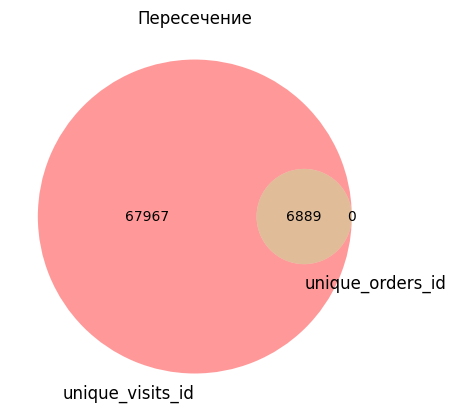

In [16]:
# Проверим, совпадают ли пользователи из таблиц
unique_visits_id = set(visits['user_id'])
unique_orders_id = set(orders['user_id'])

# Построим диаграмму Венна
venn2([unique_visits_id, unique_orders_id], set_labels=('unique_visits_id', 'unique_orders_id'))
plt.title("Пересечение")
plt.show() 

Все пользователи из таблицы с покупками присутсвуют в таблице с сессиями.

### Вывод
Для анализа метрик приложения имеем таблицы с сессиями пользователей на 161865 строк, с покупками на 33893 строк и с затратами на маркетинг на 976 строк. В таблицах собраны данные по 67967 пользователям из Индии, использовавших ПК, ТВ и мобильные устройства. Все они были привлечены через каналы `FaceBoom`, `MediaTornado`, `RocketSuperAds`, `TipTop`. Проверили данные на пропуски и дубликаты, соответствие датам и привели столбцы с датами и категориями к соответсвующим типам данных.

## Подготовка данных к когортному анализу

Найдём для каждого пользователя его дату первой сессии, канал и стоимость его привлечения

In [17]:
# Сортируем даты в порядке возрастания, чтобы корректно выделить первую дату посещения
visits = visits.sort_values(by='session_start')
# Создаём столбец с датой первого посещения для каждого пользователя 
visits['first_dt'] = visits.groupby('user_id')['session_start'].transform('min')
visits.head()

,user_id,region,device,channel,session_start,session_end,first_dt
0,631105188566,India,desktop,MediaTornado,2024-04-01,2024-04-01,2024-04-01
242,200726430135,India,mobile,FaceBoom,2024-04-01,2024-04-01,2024-04-01
241,961353726572,India,desktop,RocketSuperAds,2024-04-01,2024-04-01,2024-04-01
240,1696591151,India,mobile,FaceBoom,2024-04-01,2024-04-01,2024-04-01
239,998429147130,India,desktop,FaceBoom,2024-04-01,2024-04-01,2024-04-01


In [18]:
# Подсчитаем количество уникальных пользователей по дням и каналам
user_counts = visits.groupby(['channel', 'first_dt'])['user_id'].nunique().reset_index()
user_counts.head()

,channel,first_dt,user_id
0,FaceBoom,2024-04-01,135
1,FaceBoom,2024-04-02,100
2,FaceBoom,2024-04-03,134
3,FaceBoom,2024-04-04,106
4,FaceBoom,2024-04-05,114


In [19]:
# Объединяем с затратами на маркетинг
cac = costs.merge(user_counts, left_on=['dt', 'channel'], right_on=['first_dt', 'channel'],how='left')
cac.head()

,dt,channel,costs,first_dt,user_id
0,2024-04-01,FaceBoom,124.938874,2024-04-01,135
1,2024-04-02,FaceBoom,88.147779,2024-04-02,100
2,2024-04-03,FaceBoom,120.779457,2024-04-03,134
3,2024-04-04,FaceBoom,98.981253,2024-04-04,106
4,2024-04-05,FaceBoom,109.044760,2024-04-05,114


In [20]:
# Вычисляем CAC для каждой пары даты и канала
cac['CAC'] = cac['costs']/cac['user_id']
cac.head()

,dt,channel,costs,first_dt,user_id,CAC
0,2024-04-01,FaceBoom,124.938874,2024-04-01,135,0.925473
1,2024-04-02,FaceBoom,88.147779,2024-04-02,100,0.881478
2,2024-04-03,FaceBoom,120.779457,2024-04-03,134,0.901339
3,2024-04-04,FaceBoom,98.981253,2024-04-04,106,0.933785
4,2024-04-05,FaceBoom,109.044760,2024-04-05,114,0.956533


In [21]:
# Присоединяем полученные данные 
profiles = visits[['user_id','channel','first_dt']].merge(cac[['first_dt', 'channel','CAC']], on=['first_dt', 'channel'],how='left')
profiles = profiles.rename(columns={'channel': 'first_channel'})
profiles = profiles.drop_duplicates('user_id')
profiles.head()

,user_id,first_channel,first_dt,CAC
0,631105188566,MediaTornado,2024-04-01,0.243083
1,200726430135,FaceBoom,2024-04-01,0.925473
2,961353726572,RocketSuperAds,2024-04-01,0.873944
3,1696591151,FaceBoom,2024-04-01,0.925473
4,998429147130,FaceBoom,2024-04-01,0.925473


In [22]:
# Присоединяем данные о первом источнике привлечения и дате к данным о событиях
visits = visits.merge(profiles[['user_id','first_channel']], on = 'user_id', how = 'inner')
visits = visits.drop_duplicates()
visits.head()

,user_id,region,device,channel,session_start,session_end,first_dt,first_channel
0,631105188566,India,desktop,MediaTornado,2024-04-01,2024-04-01,2024-04-01,MediaTornado
1,631105188566,India,desktop,MediaTornado,2024-04-02,2024-04-02,2024-04-01,MediaTornado
2,200726430135,India,mobile,FaceBoom,2024-04-01,2024-04-01,2024-04-01,FaceBoom
3,961353726572,India,desktop,RocketSuperAds,2024-04-01,2024-04-01,2024-04-01,RocketSuperAds
4,1696591151,India,mobile,FaceBoom,2024-04-01,2024-04-01,2024-04-01,FaceBoom


In [23]:
# Рассчитываем дневной лайфтайм с привлечения до каждого события
visits['lifetime'] = (visits['session_start'] - visits['first_dt']).dt.days
visits.head()

,user_id,region,device,channel,session_start,session_end,first_dt,first_channel,lifetime
0,631105188566,India,desktop,MediaTornado,2024-04-01,2024-04-01,2024-04-01,MediaTornado,0
1,631105188566,India,desktop,MediaTornado,2024-04-02,2024-04-02,2024-04-01,MediaTornado,1
2,200726430135,India,mobile,FaceBoom,2024-04-01,2024-04-01,2024-04-01,FaceBoom,0
3,961353726572,India,desktop,RocketSuperAds,2024-04-01,2024-04-01,2024-04-01,RocketSuperAds,0
4,1696591151,India,mobile,FaceBoom,2024-04-01,2024-04-01,2024-04-01,FaceBoom,0


In [24]:
# Присоединяем данные о первом источнике привлечения и дате к данным о покупках
orders = orders.merge(profiles[['user_id','first_channel','first_dt']], on = 'user_id', how = 'left')
orders = orders.drop_duplicates()
orders.head()

,user_id,event_dt,revenue,first_channel,first_dt
0,771951256319,2024-04-01,2.99,FaceBoom,2024-04-01
1,829942381059,2024-04-01,2.99,FaceBoom,2024-04-01
2,727879856738,2024-04-01,14.99,FaceBoom,2024-04-01
3,481270888930,2024-04-01,2.99,TipTop,2024-04-01
4,844695029762,2024-04-01,2.99,FaceBoom,2024-04-01


In [25]:
# Рассчитываем дневной лайфтайм с привлечения до каждой покупки
orders['lifetime'] = (orders['event_dt'] - orders['first_dt']).dt.days
orders.head()

,user_id,event_dt,revenue,first_channel,first_dt,lifetime
0,771951256319,2024-04-01,2.99,FaceBoom,2024-04-01,0
1,829942381059,2024-04-01,2.99,FaceBoom,2024-04-01,0
2,727879856738,2024-04-01,14.99,FaceBoom,2024-04-01,0
3,481270888930,2024-04-01,2.99,TipTop,2024-04-01,0
4,844695029762,2024-04-01,2.99,FaceBoom,2024-04-01,0


### Вывод
Рассчитали для каждого пользователя дату, канал и стоимость привлечения, а также интервал с момента регистрации до каждого события и покупки.

## Анализ месячной динамики основных метрик продукта

Рассчитаем и построим графики DAU, MAU и Stickiness для приложения, а так же в разрезе каждого месяца рассчитает средние CAC, LTV и ROI.

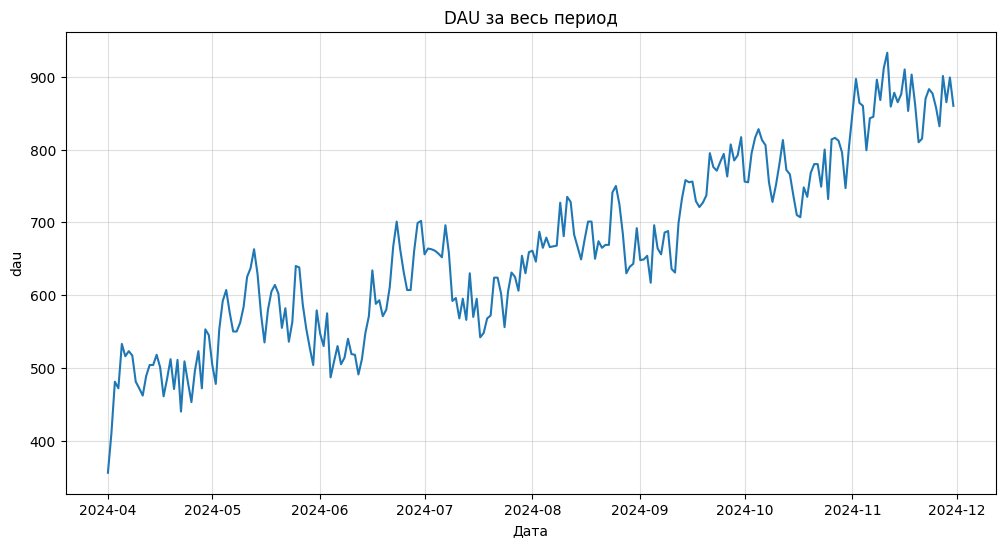

In [26]:
# Рассчитаем DAU за весь период 
dau = visits.groupby('session_start')['user_id'].nunique().reset_index()
dau = dau.rename(columns={'user_id': 'dau'})
# Построим график
plt.figure(figsize=(12, 6))
sns.lineplot(data=dau,
        x='session_start',
        y='dau')
plt.title('DAU за весь период')
plt.xlabel('Дата')
plt.grid(alpha=.4)
plt.show()

Дневная аудитория приложения росла с колебаниями на протяжении всего рассматриваемого периода с 350 до 900 пользователей. В начале лета после внедрения новой маркетинговой стратегии был временный спад, который "отбился" примерно за 2 недели.

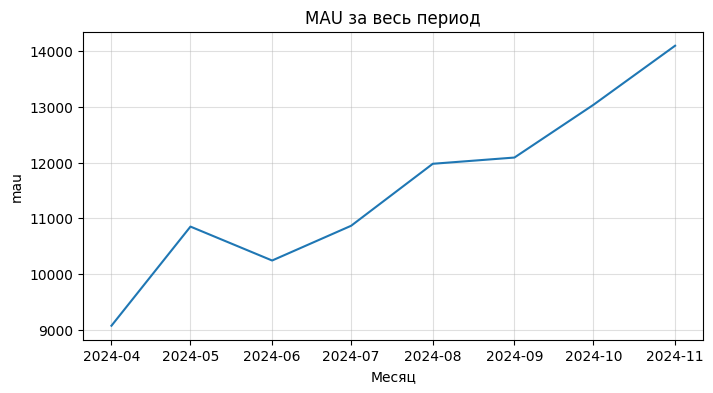

In [27]:
# Рассчитаем MAU за весь период 
month_visits = visits
month_visits['month'] = month_visits['session_start'].dt.to_period('M').dt.to_timestamp()
mau = month_visits.groupby('month')['user_id'].nunique().reset_index()
mau = mau.rename(columns={'user_id': 'mau'})
# Построим график
plt.figure(figsize=(8, 4))
sns.lineplot(data=mau,
        x='month',
        y='mau')
plt.title('MAU за весь период')
plt.xlabel('Месяц')
plt.grid(alpha=.4)
plt.show()

Месячная аудитория так же росла в течение всего периода с 9000 до 14000, и так же в июне был небольшой спад.

In [28]:
# Рассчитаем среднемесячный DAU
dau['month'] = dau['session_start'].dt.to_period('M').dt.to_timestamp()
dau['mean_dau'] = dau.groupby('month')['dau'].transform('mean')
dau

,session_start,dau,month,mean_dau
0,2024-04-01,356,2024-04-01,488.333333
1,2024-04-02,410,2024-04-01,488.333333
2,2024-04-03,481,2024-04-01,488.333333
3,2024-04-04,472,2024-04-01,488.333333
4,2024-04-05,533,2024-04-01,488.333333
...,...,...,...,...
239,2024-11-26,832,2024-11-01,868.133333
240,2024-11-27,901,2024-11-01,868.133333
241,2024-11-28,865,2024-11-01,868.133333
242,2024-11-29,899,2024-11-01,868.133333


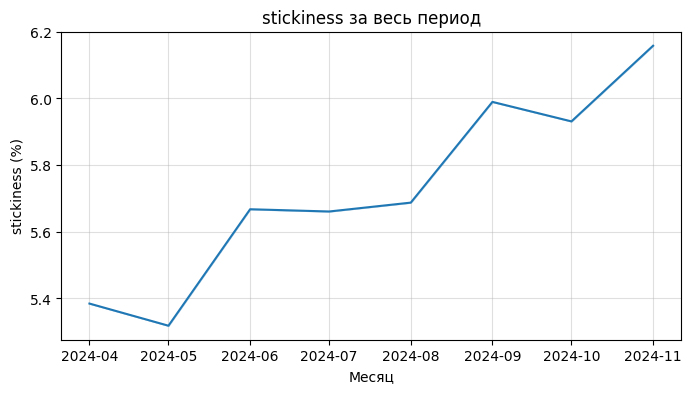

In [29]:
# Присоединяем mau и рассчитываем stickiness
stickiness = dau.merge(mau,on='month',how='left')
stickiness['stickiness'] = 100*stickiness['mean_dau']/stickiness['mau']
# Построим график
plt.figure(figsize=(8, 4))
sns.lineplot(data=stickiness,
        x='month',
        y='stickiness')
plt.title('stickiness за весь период')
plt.xlabel('Месяц')
plt.ylabel('stickiness (%)')
plt.grid(alpha=.4)
plt.show()

Прилипчивость с небольшими спадами выросла с 5.4% до 6.2% за весь период.

In [30]:
# Рассчитаем маркетинговые затраты и привлечённых пользователей по месяцам
month_costs = costs
month_costs['month'] = month_costs['dt'].dt.to_period('M').dt.to_timestamp()
month_costs = month_costs.groupby('month')['costs'].sum().reset_index()
month_users_count = visits
month_users_count['first_month'] = month_users_count['first_dt'].dt.to_period('M').dt.to_timestamp()
month_users_count = month_users_count.groupby('first_month')['user_id'].nunique().reset_index()
# Рассчитаем CAC по месяцам
month_cac = month_costs.merge(month_users_count, left_on='month', right_on='first_month',how='left')
month_cac['CAC'] = month_cac['costs']/month_cac['user_id']

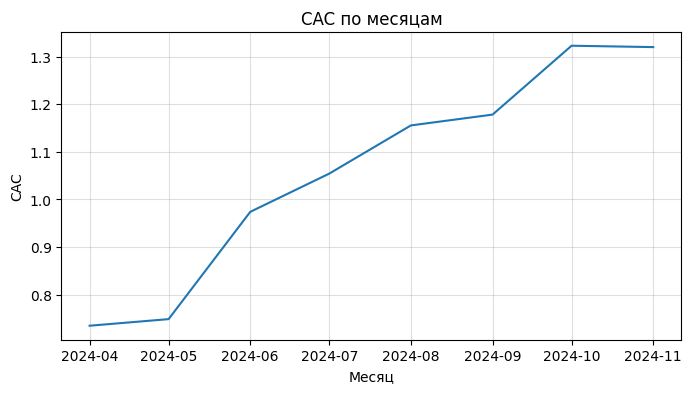

In [31]:
# Построим график
plt.figure(figsize=(8, 4))
sns.lineplot(data=month_cac,
        x='month',
        y='CAC')
plt.title('CAC по месяцам')
plt.xlabel('Месяц')
plt.grid(alpha=.4)
plt.show()

Стоимость привлечения клиентов росла каждый месяц с 0.7 до 1.3 за весь период, наибольший прирост наблюдался в июне.

In [32]:
# Фильтруем покупки сделанные за 28 дней с момента регистрации
target_days = 28
target_orders = orders[orders['lifetime']<=target_days]
target_orders['first_month'] = target_orders['first_dt'].dt.to_period('M').dt.to_timestamp()
# Рассчитываем LTV всех пользователей, привлечённых за каждый месяц
month_ltv = target_orders.groupby('first_month')['revenue'].sum().reset_index()
month_ltv

C:\Temp\ipykernel_3328\4250200058.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_orders['first_month'] = target_orders['first_dt'].dt.to_period('M').dt.to_timestamp()


,first_month,revenue
0,2024-04-01,7535.30
1,2024-05-01,8246.98
2,2024-06-01,7524.10
3,2024-07-01,10115.59
4,2024-08-01,10508.12
5,2024-09-01,10191.07
6,2024-10-01,11604.24
7,2024-11-01,8899.96


In [33]:
# Объединяем данные по CAC и LTV
month_cac_ltv = month_cac.merge(month_ltv, on = 'first_month', how = 'left')

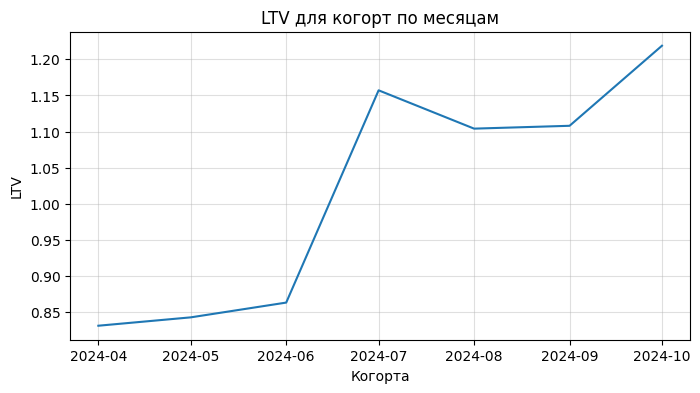

In [34]:
# Считаем среднее LTV пользователей по месяцам
month_cac_ltv['LTV'] = month_cac_ltv['revenue']/month_cac_ltv['user_id']
# Построим график
plt.figure(figsize=(8, 4))
sns.lineplot(data=month_cac_ltv[month_cac_ltv['first_month']<'2024-11-01'],
        x='first_month',
        y='LTV')
plt.title('LTV для когорт по месяцам')
plt.xlabel('Когорта')
plt.grid(alpha=.4)
plt.show()

LTV за 28 дней для пользователей по когортам вырос c 0.83 до 1.22 за весь период, наибольший рост наблюдался в июле - с 0.87 до 1.16.

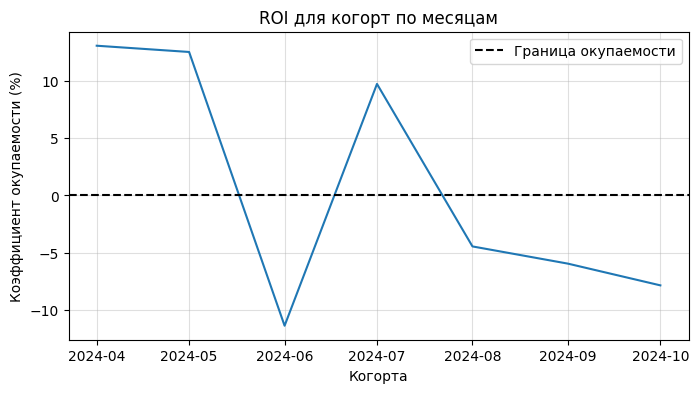

In [35]:
# Рассчитываем ROI
month_cac_ltv['ROI'] = 100*(month_cac_ltv['LTV']- month_cac_ltv['CAC'])/month_cac_ltv['CAC']
# Построим график
plt.figure(figsize=(8, 4))
sns.lineplot(data=month_cac_ltv[month_cac_ltv['first_month']<'2024-11-01'],
        x='first_month',
        y='ROI')
plt.title('ROI для когорт по месяцам')
plt.xlabel('Когорта')
plt.ylabel('Коэффициент окупаемости (%)')
plt.axhline(y=0, color='black', linestyle='--', label='Граница окупаемости')
plt.legend()
plt.grid(alpha=.4)
plt.show()

За счёт роста CAC каждый месяц ROI снизился с 13% до -8% к концу периода. В июле наблюдался резкий рост за счёт роста LTV, но общую тенденцию это не изменило.

### Вывод
Показатели активности пользователей увеличивались на протяжениии всего периода. В начале периода ROI был выше границы окупаемости, но скорость роста CAC была выше скорости роста LTV, поэтому к концу периода окупаемость была утеряна. Так же в июне после внедрения новой маркетинговой стратегии был одновременно резкий прирост CAC и LTV.

Рассмотрим метрики в разрезе каналов привлечения пользователей, чтобы определить наиболее и наименее эффективные.

## Анализ метрик в разрезе источника привлечения



Оценим какие источники имели наибольшую окупаемость и эффективность привлечения клиентов. Рассчитаем динамику набора новых пользователей по дням, а так же DAU, MAU и Stickiness в каждом источнике.
Оценим скользящее удержание на 14-й день с момента привлечения по недельным когортам и конверсию в покупку.

In [36]:
# Подсчитаем количество привлечённых пользователей по источникам
channels = profiles.groupby('first_channel')['user_id'].nunique().reset_index()
channels

,first_channel,user_id
0,FaceBoom,28401
1,MediaTornado,14080
2,RocketSuperAds,14257
3,TipTop,18118


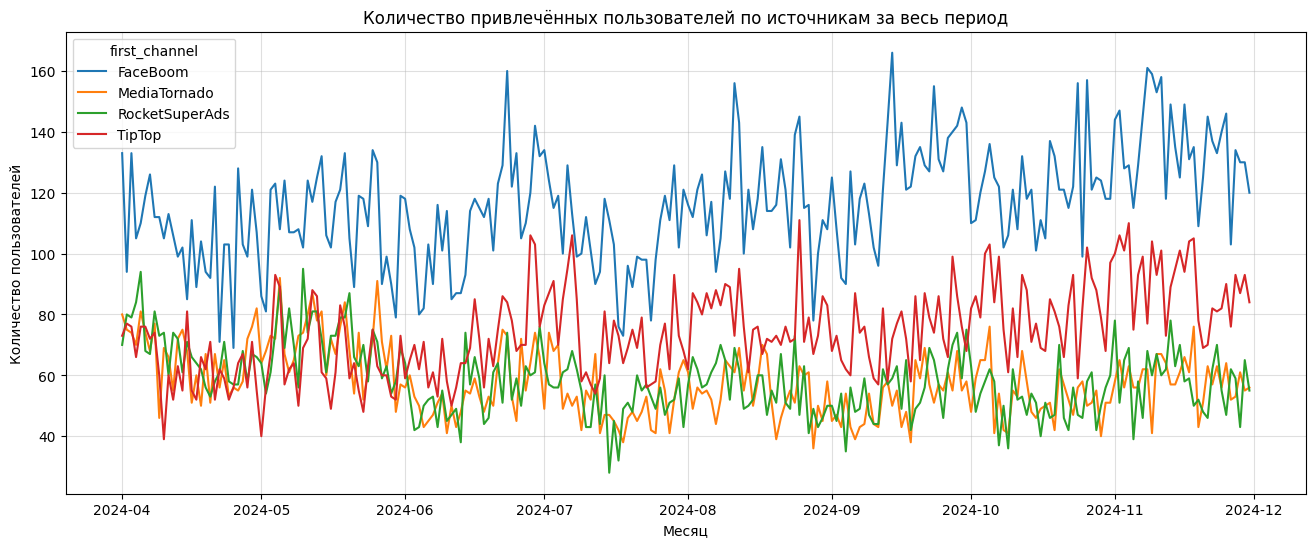

In [37]:
# Подчситаем динамику набора новых пользователей по дням в каждом источнике
daily_new_users = profiles.groupby(['first_dt','first_channel'])['user_id'].nunique().reset_index()
# Построим график
plt.figure(figsize=(16, 6))
sns.lineplot(data=daily_new_users,
        x='first_dt',
        y='user_id',
        hue='first_channel')
plt.title('Количество привлечённых пользователей по источникам за весь период')
plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.grid(alpha=.4)
plt.show()

FaceBoom привлекал наибольшее количество пользователей в течение всего периода. Остальные источники были на одном уровне до июня, после чего TipTop начал привлекать больше.

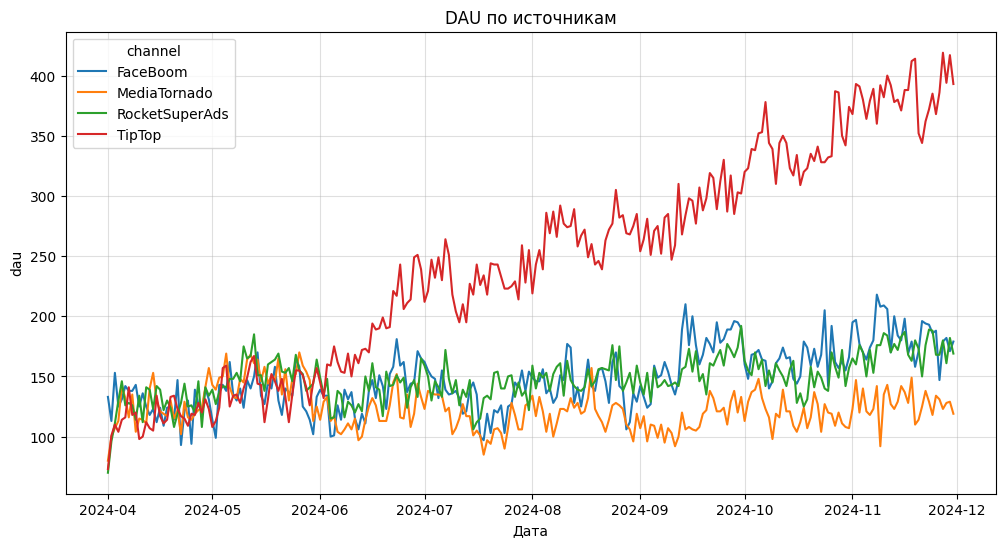

In [38]:
# Рассчитаем DAU по источникам
dau_channels = visits.groupby(['session_start','channel'])['user_id'].nunique().reset_index()
dau_channels = dau_channels.rename(columns={'user_id': 'dau'})
# Построим график
plt.figure(figsize=(12, 6))
sns.lineplot(data=dau_channels,
        x='session_start',
        y='dau',
        hue='channel')
plt.title('DAU по источникам')
plt.xlabel('Дата')
plt.grid(alpha=.4)
plt.show()

До июня все каналы привлечения показывали примерно одинаковое DAU (100-150), после июня TipTop показал стабильной рост DAU до 400 в ноябре, остальные каналы показали незначительный прирост.

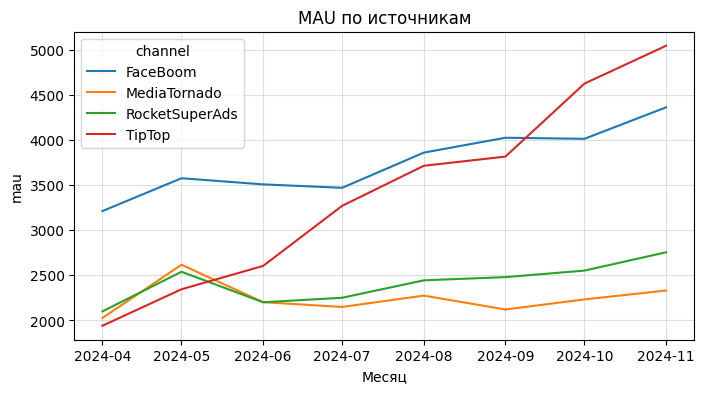

In [39]:
# Рассчитаем MAU за весь период 
mau_channels = month_visits.groupby(['month','channel'])['user_id'].nunique().reset_index()
mau_channels = mau_channels.rename(columns={'user_id': 'mau'})
# Построим график
plt.figure(figsize=(8, 4))
sns.lineplot(data=mau_channels,
        x='month',
        y='mau',
        hue='channel')
plt.title('MAU по источникам')
plt.xlabel('Месяц')
plt.grid(alpha=.4)
plt.show()

По MAU общие тенденции такие же, с той разницей, что FaceBoom изначально был на более высоком уровне, но у TipTop к октябрю MAU оказался выше.

In [40]:
# Рассчитаем среднемесячный DAU по источникам
dau_channels['month'] = dau_channels['session_start'].dt.to_period('M').dt.to_timestamp()
dau_channels['mean_dau'] = dau_channels.groupby(['month','channel'])['dau'].transform('mean')
dau_channels.head()

,session_start,channel,dau,month,mean_dau
0,2024-04-01,FaceBoom,133,2024-04-01,126.433333
1,2024-04-01,MediaTornado,80,2024-04-01,121.333333
2,2024-04-01,RocketSuperAds,70,2024-04-01,125.066667
3,2024-04-01,TipTop,73,2024-04-01,115.500000
4,2024-04-02,FaceBoom,113,2024-04-01,126.433333


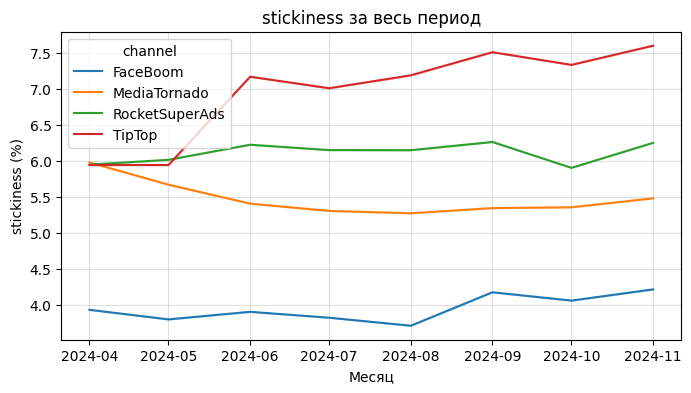

In [41]:
# Присоединяем mau и рассчитываем stickiness по источникам
stickiness_channels = dau_channels.merge(mau_channels,on=['month','channel'],how='left')
stickiness_channels['stickiness'] = 100*stickiness_channels['mean_dau']/stickiness_channels['mau']
# Построим график
plt.figure(figsize=(8, 4))
sns.lineplot(data=stickiness_channels,
        x='month',
        y='stickiness',
        hue='channel')
plt.title('stickiness за весь период')
plt.xlabel('Месяц')
plt.ylabel('stickiness (%)')
plt.grid(alpha=.4)
plt.show()

Прилипчивость за весь период росла только у TipTop, наибольший прирост в июне. FaceBoom показывал результат хуже остальных каналов.

In [42]:
# Добавляем недельные когорты в данные о посещениях
visits['first_week'] = visits['first_dt'].dt.to_period('W').dt.to_timestamp()
# Для расчёта скользящего удержания фильтруем посещения от 14 до 28 дня
filtered_visits = visits[(visits['lifetime']>=14) & (visits['lifetime']<=target_days)]
filtered_visits.head()

,user_id,region,device,channel,session_start,session_end,first_dt,first_channel,lifetime,month,first_month,first_week
39,397627300533,India,desktop,TipTop,2024-04-28,2024-04-28,2024-04-01,TipTop,27,2024-04-01,2024-04-01,2024-04-01
65,795286967735,India,mobile,RocketSuperAds,2024-04-24,2024-04-24,2024-04-01,RocketSuperAds,23,2024-04-01,2024-04-01,2024-04-01
88,352578154912,India,desktop,TipTop,2024-04-20,2024-04-20,2024-04-01,RocketSuperAds,19,2024-04-01,2024-04-01,2024-04-01
116,615172047008,India,mobile,MediaTornado,2024-04-18,2024-04-18,2024-04-01,MediaTornado,17,2024-04-01,2024-04-01,2024-04-01
123,150256217506,India,mobile,TipTop,2024-04-20,2024-04-20,2024-04-01,TipTop,19,2024-04-01,2024-04-01,2024-04-01


In [43]:
# Считаем оставшихся посетителей по когортам и источникам
cohort_retention = filtered_visits.groupby(['first_week','channel'])['user_id'].nunique().reset_index()
cohort_retention.head()

,first_week,channel,user_id
0,2024-04-01,FaceBoom,14
1,2024-04-01,MediaTornado,51
2,2024-04-01,RocketSuperAds,67
3,2024-04-01,TipTop,67
4,2024-04-08,FaceBoom,12


In [44]:
# Считаем изначальных посетителей по когортам и источникам
total_users = visits.groupby(['first_week','channel'])['user_id'].nunique().reset_index()
total_users = total_users.rename(columns={'user_id': 'total_users'})
total_users.head()

,first_week,channel,total_users
0,2024-04-01,FaceBoom,842
1,2024-04-01,MediaTornado,543
2,2024-04-01,RocketSuperAds,568
3,2024-04-01,TipTop,531
4,2024-04-08,FaceBoom,771


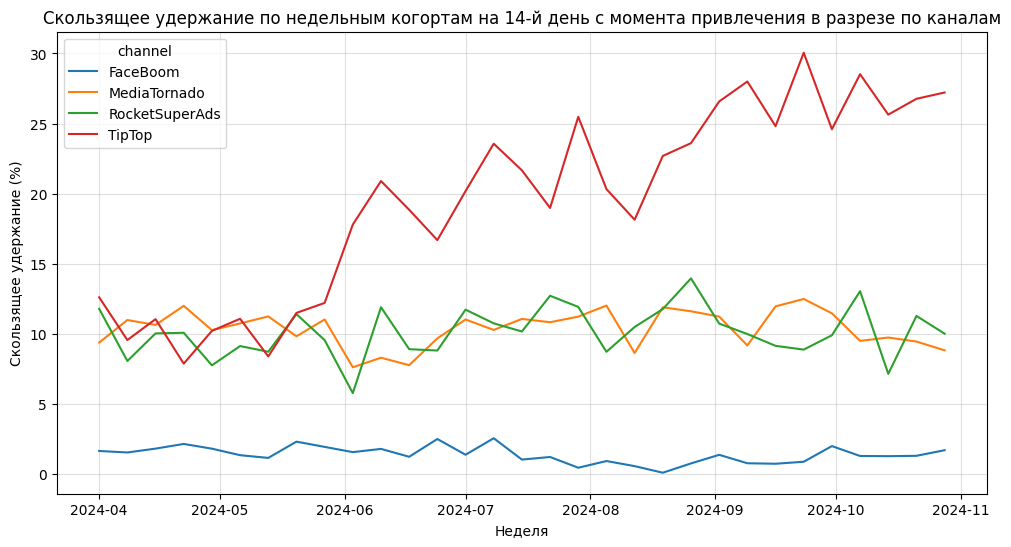

In [45]:
# Объединяем таблицы и считаем скользящее удержание
cohort_retention = cohort_retention.merge(total_users, on=['first_week','channel'], how='left')
cohort_retention['rolling_retention'] = 100*(cohort_retention['user_id']/cohort_retention['total_users'])
# Построим график
plt.figure(figsize=(12, 6))
sns.lineplot(data=cohort_retention[cohort_retention['first_week']<'2024-11-01'],
        x='first_week',
        y='rolling_retention',
        hue='channel')
plt.title('Скользящее удержание по недельным когортам на 14-й день с момента привлечения в разрезе по каналам')
plt.xlabel('Неделя')
plt.ylabel('Скользящее удержание (%)')
plt.grid(alpha=.4)
plt.show()

Скользящее удержание на 14-ый день по недельным когортам для всех каналов было стабильным до июня, у FaceBoom оно близко к нулю. После июня начало рости для TipTop, у остальных каналов осталось примерно на изначальном уровне.

In [46]:
# Выделяем недельные когорты и фильтруем покупки до 28 дня
orders['first_week'] = orders['first_dt'].dt.to_period('W').dt.to_timestamp()
filtered_orders = orders[orders['lifetime']<=target_days]
filtered_orders.head()

,user_id,event_dt,revenue,first_channel,first_dt,lifetime,first_week
0,771951256319,2024-04-01,2.99,FaceBoom,2024-04-01,0,2024-04-01
1,829942381059,2024-04-01,2.99,FaceBoom,2024-04-01,0,2024-04-01
2,727879856738,2024-04-01,14.99,FaceBoom,2024-04-01,0,2024-04-01
3,481270888930,2024-04-01,2.99,TipTop,2024-04-01,0,2024-04-01
4,844695029762,2024-04-01,2.99,FaceBoom,2024-04-01,0,2024-04-01


In [47]:
# Считаем покупателей по когортам и источникам
cohort_conversion = filtered_orders.groupby(['first_week','first_channel'])['user_id'].nunique().reset_index()
cohort_conversion.head()

,first_week,first_channel,user_id
0,2024-04-01,FaceBoom,93
1,2024-04-01,MediaTornado,24
2,2024-04-01,RocketSuperAds,45
3,2024-04-01,TipTop,48
4,2024-04-08,FaceBoom,78


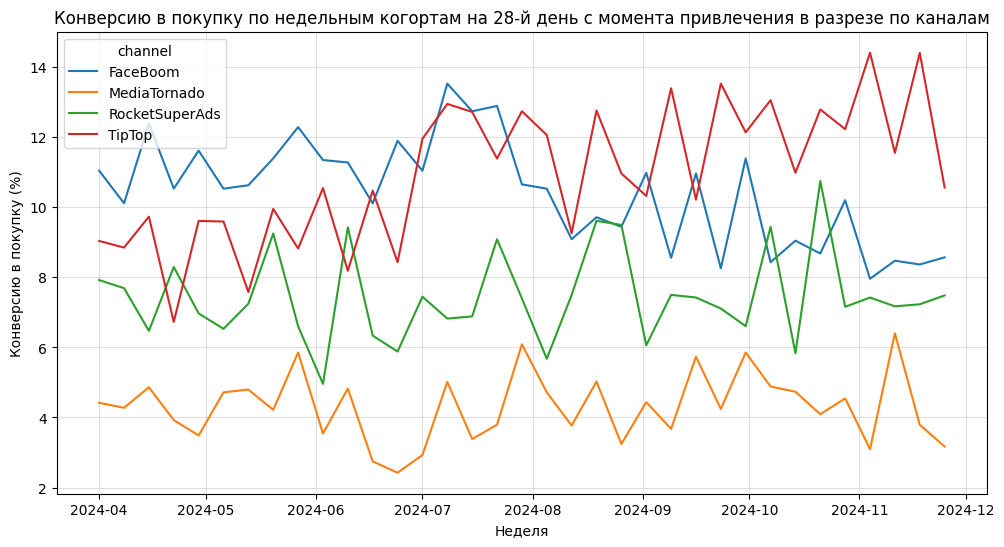

In [48]:
# Объединяем с общим количеством пользователей в когорте и считаем конверсию
cohort_conversion = cohort_conversion.merge(total_users, left_on=['first_week','first_channel'], right_on=['first_week','channel'],how='left')
cohort_conversion['conversion'] = 100*(cohort_conversion['user_id']/cohort_conversion['total_users'])
# Построим график
plt.figure(figsize=(12, 6))
sns.lineplot(data=cohort_conversion,
        x='first_week',
        y='conversion',
        hue='channel')
plt.title('Конверсию в покупку по недельным когортам на 28-й день с момента привлечения в разрезе по каналам')
plt.xlabel('Неделя')
plt.ylabel('Конверсию в покупку (%)')
plt.grid(alpha=.4)
plt.show()

К концу периода TipTop показал лучшую конверсию в покупку (10-14%) за 28 дней, FaceBoom показал спад до 9%, у RocketSuperAds весь период конверсия была 6-10%, у MediaTornado - 3-6%.

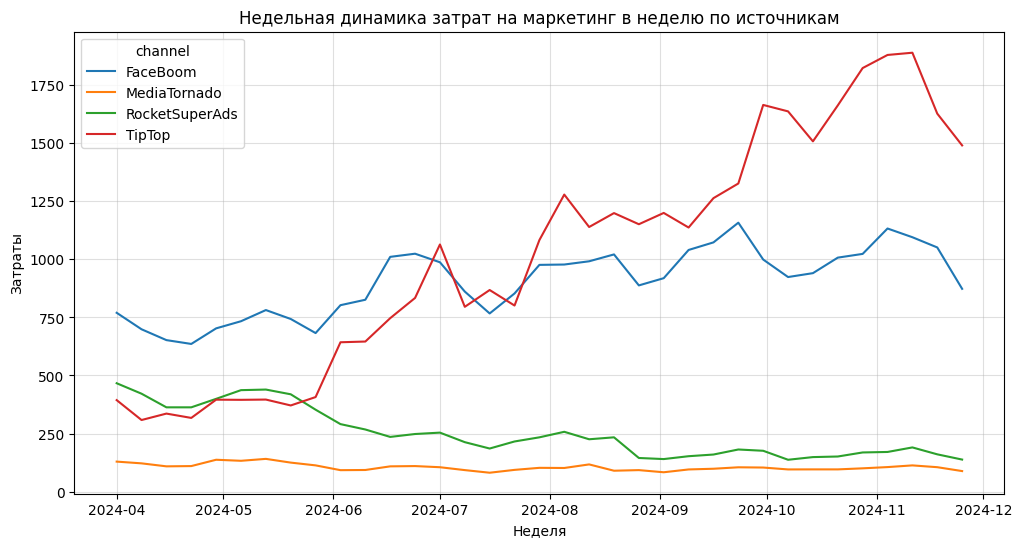

In [49]:
# Выделяем недельные затраты на маркетинг по источникам
costs['week'] = costs['dt'].dt.to_period('W').dt.to_timestamp()
week_costs = costs.groupby(['week','channel'])['costs'].sum().reset_index()
# Построим график
plt.figure(figsize=(12, 6))
sns.lineplot(data=week_costs,
        x='week',
        y='costs',
        hue='channel')
plt.title('Недельная динамика затрат на маркетинг в неделю по источникам')
plt.xlabel('Неделя')
plt.ylabel('Затраты')
plt.grid(alpha=.4)
plt.show()

Недельные затраты на маркетинг наиболее активно росли у TipTop начиная с июня и достигли 1800 к концу периода, у FaceBoom - около 1000, у RocketSuperAds и MediaTornado - наоборот спали до 100-150 к концу периода.

In [50]:
# Рассчитаем привлечённых пользователей по неделям и источникам
week_users_count = visits.groupby(['first_week','channel'])['user_id'].nunique().reset_index()
# Объединям с маркетинговыми затратами
week_cac = week_users_count.merge(week_costs, left_on=['first_week','channel'],right_on=['week','channel'],how='left')
week_cac

,first_week,channel,user_id,week,costs
0,2024-04-01,FaceBoom,842,2024-04-01,769.875901
1,2024-04-01,MediaTornado,543,2024-04-01,129.318322
2,2024-04-01,RocketSuperAds,568,2024-04-01,466.650000
3,2024-04-01,TipTop,531,2024-04-01,393.989381
4,2024-04-08,FaceBoom,771,2024-04-08,698.872741
...,...,...,...,...,...
135,2024-11-18,TipTop,583,2024-11-18,1627.048850
136,2024-11-25,FaceBoom,770,2024-11-25,872.983777
137,2024-11-25,MediaTornado,347,2024-11-25,88.593183
138,2024-11-25,RocketSuperAds,334,2024-11-25,138.125000


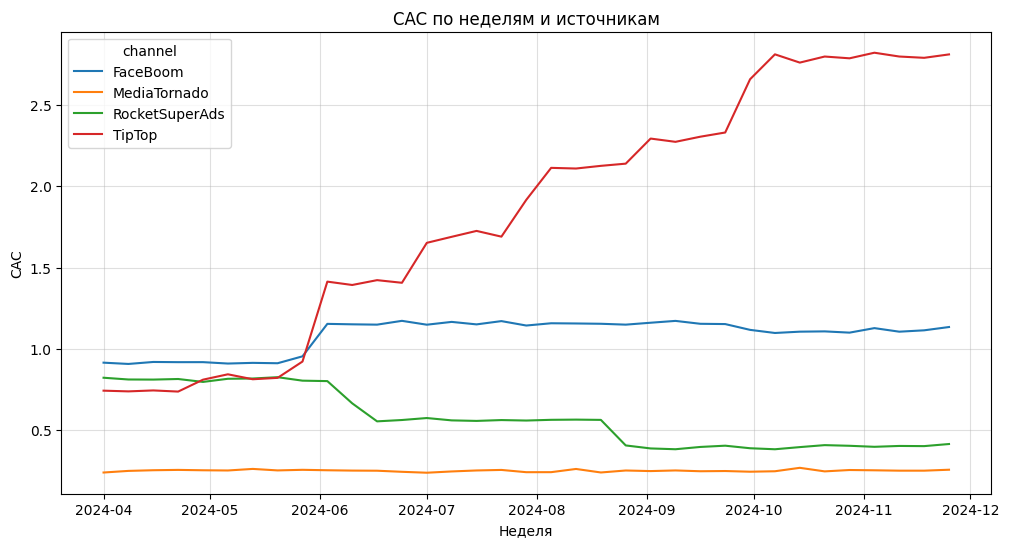

In [51]:
# Рассчитаем CAC по неделям и источникам
week_cac['CAC'] = week_cac['costs']/week_cac['user_id']
# Построим график
plt.figure(figsize=(12, 6))
sns.lineplot(data=week_cac,
        x='week',
        y='CAC',
        hue='channel')
plt.title('CAC по неделям и источникам')
plt.xlabel('Неделя')
plt.grid(alpha=.4)
plt.show()

До июня CAC по каналам был стабилен, но после вырос с 0.7 до 2.8 для TipTop, незначительно вырос для FaceBoom, для RocketSuperAds снизился с 0.8 до 0.4, а для MediaTornado был около 0.3 весь период.

In [52]:
# Выделяем неделю для покупок сделанных в течение 28 дней
target_orders = target_orders.copy()
target_orders['first_week'] = target_orders['first_dt'].dt.to_period('W').dt.to_timestamp()
# Рассчитываем LTV всех пользователей, привлечённых за каждую неделю
week_ltv = target_orders.groupby(['first_week','first_channel'])['revenue'].sum().reset_index()
week_ltv.head()

,first_week,first_channel,revenue
0,2024-04-01,FaceBoom,380.36
1,2024-04-01,MediaTornado,191.43
2,2024-04-01,RocketSuperAds,739.28
3,2024-04-01,TipTop,798.39
4,2024-04-08,FaceBoom,337.06


In [53]:
# Объединяем данные по CAC и LTV
week_cac_ltv = week_cac.merge(week_ltv, left_on=['first_week','channel'],right_on=['first_week','first_channel'],how='left')
week_cac_ltv.head()

,first_week,channel,user_id,week,costs,CAC,first_channel,revenue
0,2024-04-01,FaceBoom,842,2024-04-01,769.875901,0.914342,FaceBoom,380.36
1,2024-04-01,MediaTornado,543,2024-04-01,129.318322,0.238155,MediaTornado,191.43
2,2024-04-01,RocketSuperAds,568,2024-04-01,466.650000,0.821567,RocketSuperAds,739.28
3,2024-04-01,TipTop,531,2024-04-01,393.989381,0.741976,TipTop,798.39
4,2024-04-08,FaceBoom,771,2024-04-08,698.872741,0.906450,FaceBoom,337.06


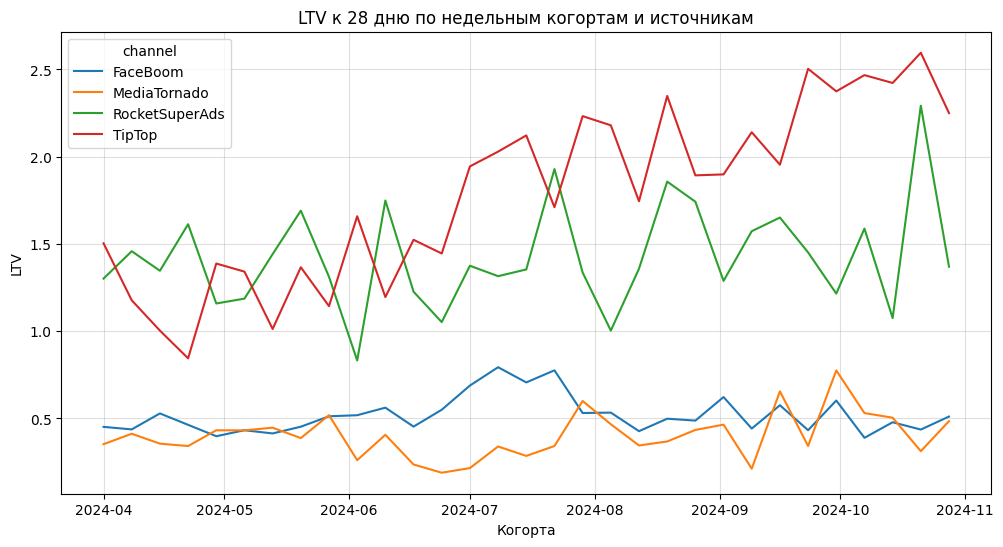

In [54]:
# Считаем среднее LTV пользователей по неделям и источникам
week_cac_ltv['LTV'] = week_cac_ltv['revenue']/week_cac_ltv['user_id']
# Построим график
plt.figure(figsize=(12, 6))
sns.lineplot(data=week_cac_ltv[week_cac_ltv['first_week']<'2024-11-01'],
        x='first_week',
        y='LTV',
        hue='channel')
plt.title('LTV к 28 дню по недельным когортам и источникам')
plt.xlabel('Когорта')
plt.grid(alpha=.4)
plt.show()

LTV к 28 дню для FaceBoom и MediaTornado был около 0.5 в течение всего периода. Лучшие результаты показали TipTop и RocketSuperAds, для них он колебался от 1 до 2.5, TipTop показал наибольший прирост.

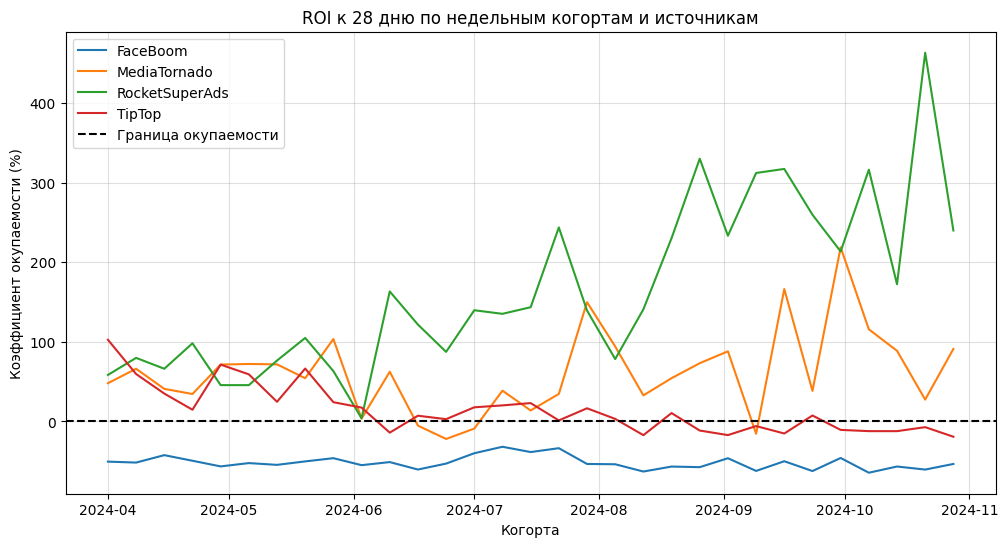

In [55]:
# Рассчитываем ROI
week_cac_ltv['ROI'] = 100*(week_cac_ltv['LTV']- week_cac_ltv['CAC'])/week_cac_ltv['CAC']
# Построим график
plt.figure(figsize=(12, 6))
sns.lineplot(data=week_cac_ltv[week_cac_ltv['first_week']<'2024-11-01'],
        x='first_week',
        y='ROI',
        hue='channel')
plt.title('ROI к 28 дню по недельным когортам и источникам')
plt.xlabel('Когорта')
plt.ylabel('Коэффициент окупаемости (%)')
plt.axhline(y=0, color='black', linestyle='--', label='Граница окупаемости')
plt.legend()
plt.grid(alpha=.4)
plt.show()

ROI к 28 дню был наиболее высоким практически весь период у RocketSuperAds за счёт низкого CAC. Для TipTop он стабильно падал из-за роста CAC и концу периода перестал окупаться. У MediaTornado был примерно на одном уровне, так как CAC и LTV практически не менялись. FaceBoom весь период не выходил на окупаемость за 28 дней.

### Вывод
Общая характеристика для каждого канала:
- FaceBoom привлёк наибольшее количество пользователей за весь период, но это были незаинтересованные пользователи. Данный канал показал самые низкие прилипчивость и удержание. И хотя конверсию в покупку довольно высокая относительно других каналов, у покупающих пользователей низкий LTV, что говорит о низкой стоимости их покупок. Это вкупе с высокими затратами на маркетинг даёт худшую окупаемость на 28 день, все когорты не вышли на окупаемость.
- TipTop на 2 месте по количеству привлечённых пользователей, и эти пользователи показали наибольшую активность - прилипчивость и удержание с большим отрывом самые высокие. Конверсия в покупку и LTV также наивысшие у данного канала, но с другой стороны общие затраты на маркетинг и CAC по пользователям тоже высоки, поэтому данный канал перестал окупаться к концу периода. Данный канал привлекает наиболее платежёспособных и активных пользователей, но цена их привлечения высока и увеличивается с каждым месяцем.
- MediaTornado привлёк наименьшее количество пользователей, их активность была невыской - 3-ее место по прилипчивости и удержанию. Конверсия в покупку была самой низкой, LTV на одном уровне с FaceBoom, но при этом и самые низкие затраты на маркетинг. В итоге - 2 место по окупаемости с учётом периодических "провалов" в течение рассматриваемого периода.
- RocketSuperAds на 3 месте по количеству привлечённых пользователей. Они показывают неплохую активность - 2 место по прилипчивости и удержанию. Конверсия в покупку 3-яя среди каналов, но при этом LTV почти на уровне TipTop. При этом затраты на маркетинг падали на протяжении всего периода, поэтому данный канал показал наилучшую окупаемость инвестиций.

## Анализ периода окупаемости маркетинговых вложений

Так как каналы `FaceBoom` и `TipTop` за целевые 28 дней не выходят на окупаемость, рассмотрим динамику окупаемости на более длительном промежутке в 10 недель.

In [56]:
# Для источника FaceBoom расммотрим ROI за период в 10 недель
new_target_days = 70
new_target_orders = orders[orders['lifetime']<=new_target_days]
# Выделяем неделю покупки
new_target_orders = new_target_orders.copy()
new_target_orders['event_week'] = new_target_orders['event_dt'].dt.to_period('W').dt.to_timestamp()
new_target_orders['n_week'] = ((new_target_orders['event_week'] - new_target_orders['first_week']).dt.days)/7
# Считаем сумму стоимости покупок платящих пользователей по неделям и когортам
new_target_orders_revenue = new_target_orders.groupby(['first_week','event_week','n_week','first_channel'])['revenue'].sum().reset_index()
new_target_orders_revenue.head()

,first_week,event_week,n_week,first_channel,revenue
0,2024-04-01,2024-04-01,0.0,FaceBoom,290.63
1,2024-04-01,2024-04-01,0.0,MediaTornado,109.15
2,2024-04-01,2024-04-01,0.0,RocketSuperAds,231.74
3,2024-04-01,2024-04-01,0.0,TipTop,272.76
4,2024-04-01,2024-04-01,1.0,FaceBoom,0.00


In [57]:
# Объединяем таблицы
week_ltv_cac = new_target_orders_revenue.merge(week_cac[['first_week','channel','CAC','user_id']],
                                               left_on=['first_week','first_channel'],
                                               right_on=['first_week','channel']
                                               ,how='left')
# Сортируем для корректного подсчёта кумулятивной суммы стоимости покупок
week_ltv_cac = week_ltv_cac.sort_values(by=['first_week','n_week'])
week_ltv_cac.head()

,first_week,event_week,n_week,first_channel,revenue,channel,CAC,user_id
0,2024-04-01,2024-04-01,0.0,FaceBoom,290.63,FaceBoom,0.914342,842
1,2024-04-01,2024-04-01,0.0,MediaTornado,109.15,MediaTornado,0.238155,543
2,2024-04-01,2024-04-01,0.0,RocketSuperAds,231.74,RocketSuperAds,0.821567,568
3,2024-04-01,2024-04-01,0.0,TipTop,272.76,TipTop,0.741976,531
44,2024-04-01,2024-04-08,0.0,FaceBoom,0.00,FaceBoom,0.914342,842


In [58]:
# Рассчитываем кумулятивную сумму выручки по когортам и неделям
week_ltv_cac['cumsum_revenue'] = week_ltv_cac.groupby(['first_week','channel'])['revenue'].cumsum()
# Рассчитываем LTV по когортам и неделям
week_ltv_cac['LTV'] = week_ltv_cac['cumsum_revenue']/week_ltv_cac['user_id']
week_ltv_cac.head()

,first_week,event_week,n_week,first_channel,revenue,channel,CAC,user_id,cumsum_revenue,LTV
0,2024-04-01,2024-04-01,0.0,FaceBoom,290.63,FaceBoom,0.914342,842,290.63,0.345166
1,2024-04-01,2024-04-01,0.0,MediaTornado,109.15,MediaTornado,0.238155,543,109.15,0.201013
2,2024-04-01,2024-04-01,0.0,RocketSuperAds,231.74,RocketSuperAds,0.821567,568,231.74,0.407993
3,2024-04-01,2024-04-01,0.0,TipTop,272.76,TipTop,0.741976,531,272.76,0.513672
44,2024-04-01,2024-04-08,0.0,FaceBoom,0.00,FaceBoom,0.914342,842,290.63,0.345166


In [59]:
# Подсчитываем ROI
week_ltv_cac['ROI'] = 100*(week_ltv_cac['LTV']-week_ltv_cac['CAC'])/week_ltv_cac['CAC']
# Сводим данные в сводные таблицы по каналам
pivot_faceboom = week_ltv_cac[week_ltv_cac['channel']=='FaceBoom'].pivot_table(index='first_week', columns='n_week', values='ROI')
pivot_tiptop = week_ltv_cac[week_ltv_cac['channel']=='TipTop'].pivot_table(index='first_week', columns='n_week', values='ROI')

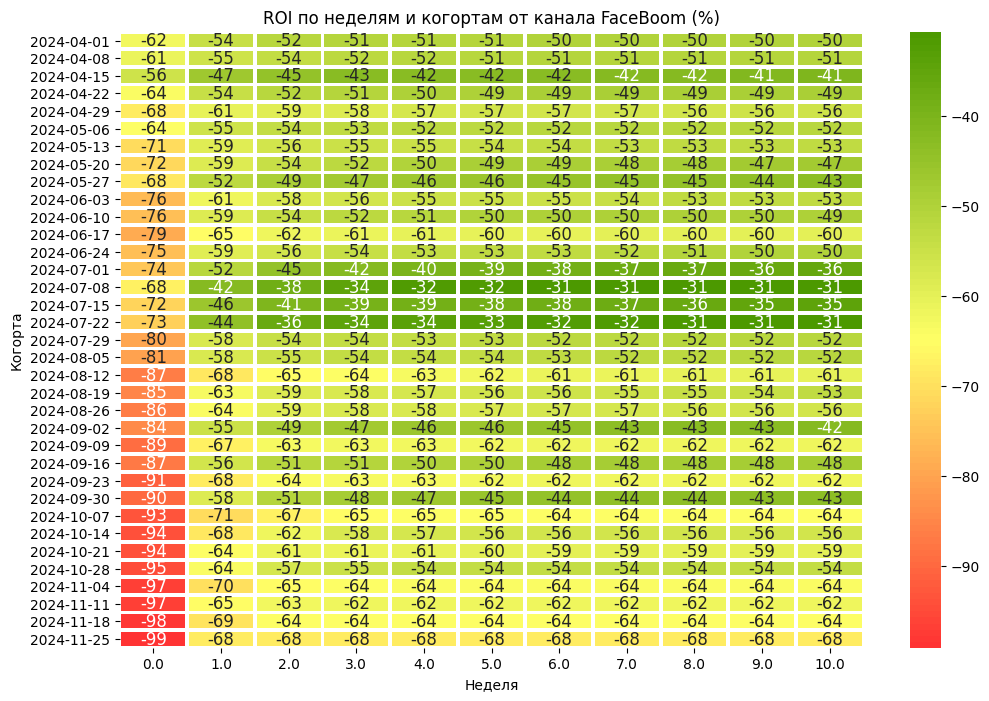

In [60]:
# Выводим тепловую карту для канала FaceBoom
pivot_faceboom.index = pd.to_datetime(pivot_faceboom.index).strftime('%Y-%m-%d')
plt.figure(figsize=(12, 8))
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)
sns.heatmap(pivot_faceboom,
          cmap=cmap,
          annot=True,
          fmt='.0f',
          linewidths=2,
          annot_kws={"size": 12})
plt.title('ROI по неделям и когортам от канала FaceBoom (%)')
plt.xlabel('Неделя')
plt.ylabel('Когорта')
plt.show()

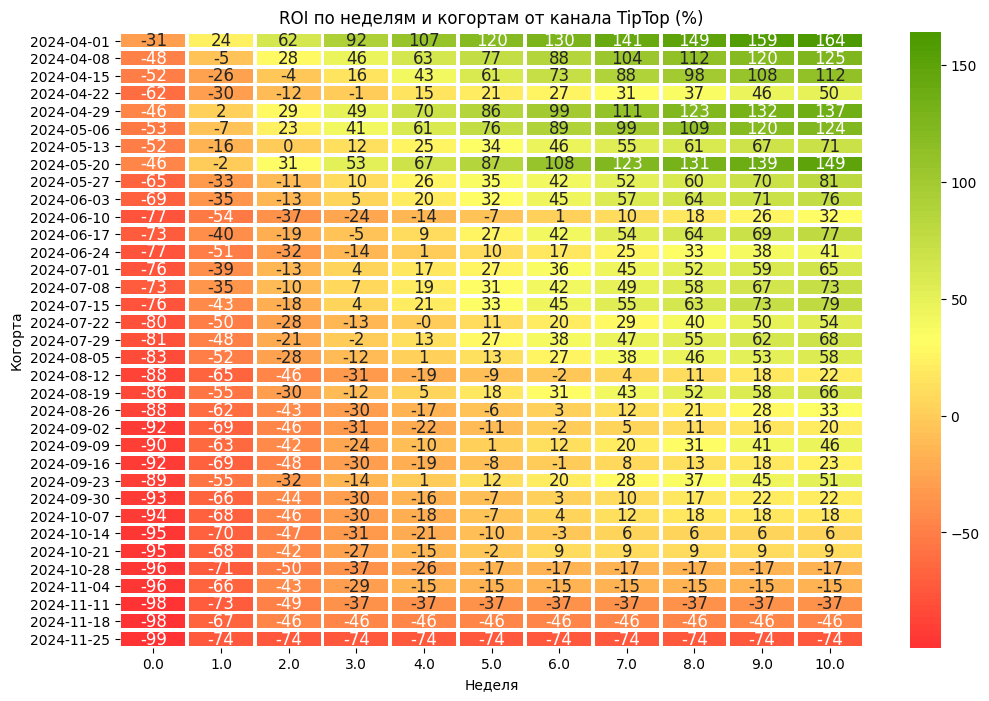

In [61]:
# Выводим тепловую карту для канала TipTop
pivot_tiptop.index = pd.to_datetime(pivot_tiptop.index).strftime('%Y-%m-%d')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_tiptop,
          cmap=cmap,
          annot=True,
          fmt='.0f',
          linewidths=2,
          annot_kws={"size": 12})
plt.title('ROI по неделям и когортам от канала TipTop (%)')
plt.xlabel('Неделя')
plt.ylabel('Когорта')
plt.show()

На конец рассматриваемого периода пользователи от TipTop выходят на окупаемость к 6-7 неделе с момента привлечения. Но в каждой последующей когорте окупаемость растёт всё медленнее.

### Вывод
Пользователи, привлечённые через FaceBoom, не выходят на окупаемость даже на 10 неделю с момента привлечения ни в одной из когорт.

Пользователи, привлечённые через TipTop на конец рассматриваемого периода выходят на окупаемость к 6-7 неделе с момента привлечения. Но в каждой последующей когорте окупаемость растёт всё медленнее.

## Выводы и рекомендации

Аудитория продукта увеличивалась на протяжении всего периода. В начале периода ROI был выше границы окупаемости, но скорость роста CAC была выше скорости роста LTV, поэтому к концу периода окупаемость была утеряна. Но данные тенденции относятся не ко всем каналам привлечения пользователей, рассмотрим их по отдельности:

- FaceBoom привлёк наибольшее количество пользователей за весь период, но это были незаинтересованные пользователи. Данный канал показал самые низкие прилипчивость и удержание. И хотя конверсию в покупку довольно высокая относительно других каналов, у покупающих пользователей низкий LTV, что говорит о низкой стоимости их покупок. Это вкупе с высокими затратами на маркетинг даёт худшую окупаемость на 28 день, все когорты не вышли на окупаемость.
- TipTop на 2 месте по количеству привлечённых пользователей, и эти пользователи показали наибольшую активность - прилипчивость и удержание с большим отрывом самые высокие. Конверсия в покупку и LTV также наивысшие у данного канала, но с другой стороны общие затраты на маркетинг и CAC по пользователям тоже высоки, поэтому данный канал перестал окупаться к концу периода. Данный канал привлекает наиболее платежёспособных и активных пользователей, но цена их привлечения высока и увеличивается с каждым месяцем.
- MediaTornado привлёк наименьшее количество пользователей, их активность была невыской - 3-ее место по прилипчивости и удержанию. Конверсия в покупку была самой низкой, LTV на одном уровне с FaceBoom, но при этом и самые низкие затраты на маркетинг. В итоге - 2 место по окупаемости с учётом периодических "провалов" в течение рассматриваемого периода.
- RocketSuperAds на 3 месте по количеству привлечённых пользователей. Они показывают неплохую активность - 2 место по прилипчивости и удержанию. Конверсия в покупку 3-яя среди каналов, но при этом LTV почти на уровне TipTop. При этом затраты на маркетинг падали на протяжении всего периода, поэтому данный канал показал наилучшую окупаемость инвестиций.

Для каналов FaceBoom и TipTop, которые не выходят на окупаемость за 28 дней, был рассмотрен период в 10 недель. 
FaceBoom не достигает уровня окупаемости ни в одной из когорт, в то время как TipTop выходит на этот уровень к 6-7 неделе.

Рекомендации для отдела маркетинга:
- Рекомендуется пересмотреть распределение бюджетов по каналам. Канал RocketSuperAds показывает наивысшую окупаемость, на него стоит ставить приоритет, в то время как FaceBoom не достигает окупаемости, от него стоит отказаться.
- TipTop привлекает наиболее платежёспособных и активных пользователей, но цена их привлечения высока и увеличивается с каждым месяцем. Рекомендуется провести отдельное исследование и понять причину этого увеличения.